## Обучение SVC +USE

#### Задача: Определить является ли новость фэйковой по заголовку
#### Данные: Заголовки новостных статей, метка 1/0 - фэйк/не фэйк

### Содержание:
    1. Подгрузка и анализ данных
    2. Подготовка пайпа для подбора гиперпараметров для SVC и LogReg
    3. USE+SVC
    4. Дообучим bert сеть на основе предобученной модели cointegrated/rubert-tiny в отдельном проекте
    5. Выводы

In [2]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import spacy
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC
from tqdm import tqdm


%matplotlib inline

In [ ]:
#качаем модель для русского языка
!python3 -m spacy download ru_core_news_sm

## Подгрузка и анализ данных

In [ ]:
# поднимаем модель
nlp = spacy.load('ru_core_news_sm')

In [11]:
DATA_PATH = Path().cwd().parent.joinpath('data')

In [12]:
# подгружаем датасет и разбиваем его на train/test с сохранением пропрции классов
df = pd.read_csv(DATA_PATH.joinpath('train.tsv'), sep='\t')

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['is_fake'])

In [13]:
df_train.sample(10).style.set_properties(subset=["title"], **{"width-min": "300px"})

,title,is_fake
1496,Песня со словами «Не нужен мне берег турецкий» стала новым гимном Ростуризма,1
507,Подозреваемого в многомиллиардной растрате трейдера UBS задержали,0
5699,"Новая работа Германа Стерлигова, новая роль Михаила Ефремова, новый башкирский штамм коронавируса и статус Талибана* в нашей традиционной рубрике «Панорама недели»",1
1779,Сенсорный смартфон Palm Pre поступил в продажу,0
1684,В хабаровском зоопарке рысь обматерила посетителей,1
5753,Эдди Чемберс получил сотрясение мозга в бою с Кличко,0
1121,С 1 мая аккредитация журналистов в Госдуме не распространяется на столовую,1
5471,ФАС запретила Apple продавать iPhone 13 в России дороже 25 тысяч рублей,1
5325,"В Перми арестовали учителя труда, который обучал детей программированию",1
3959,Овечкин набрал два очка в матче НХЛ,0


#### Беглый анализ выборок

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4606 entries, 4393 to 2383
Data columns (total 2 columns):
title      4606 non-null object
is_fake    4606 non-null int64
dtypes: int64(1), object(1)
memory usage: 108.0+ KB


In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 1959 to 1215
Data columns (total 2 columns):
title      1152 non-null object
is_fake    1152 non-null int64
dtypes: int64(1), object(1)
memory usage: 27.0+ KB


In [18]:
df_train.is_fake.value_counts()

1    2303
0    2303
Name: is_fake, dtype: int64

In [15]:
# подсчет длин предложений (по количеству слов) для гистограммы
sentence_lenghts = [len(x.split(' ')) for x in df_train.title.values.tolist()]

(array([ 17.,  88., 311., 555., 698., 761., 658., 455., 381., 259., 169.,
        106.,  60.,  32.,  18.,   9.,   6.,   6.,   6.,   2.,   6.,   0.,
          2.]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26]),
 <BarContainer object of 23 artists>)

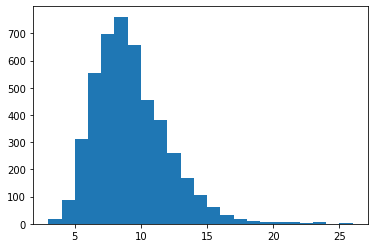

In [16]:
plt.hist(sentence_lenghts, bins=range(min(sentence_lenghts), max(sentence_lenghts)))

#### Выборки сбалансированы, тексты короткие, будем использовать простую предобработку с минимальными изменениями исходных текстов 

In [17]:
def text_process(text):
    text = text.lower()
    # удаляем пунктуацию
    text = re.sub(r'[^\w0-9\s]', '', text)
    # удаляем числа
    text = re.sub(r'\d+', '', text)
    
    return text

In [ ]:
# удаляем частице "не" из списка стоп-слов
deselect_stop_words = ['не']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False
    
# процедура удаления стоп-слов
def remove_stop_words(text):
    #токенизация текста
    doc = nlp(text)

    clean_text = []
    
    for token in doc:
        if not token.is_stop: 
            clean_text.append(token.text)
    return ' '.join(clean_text)

In [13]:
# проверяем препроцессинг текста
text_process('«Аэрофлоту» запретят летать в Европу, пока авиакомпания не соблюдет квоту по трансгендерам')

'аэрофлоту запретят летать в европу пока авиакомпания не соблюдет квоту по трансгендерам'

In [47]:
# проверяем очистку текста от стоп-слов
remove_stop_words('«Аэрофлоту» запретят летать в Европу, пока авиакомпания не соблюдет квоту по трансгендерам')

'« Аэрофлоту » запретят летать Европу , авиакомпания не соблюдет квоту трансгендерам'

#### Запускаем обработку текста на тренировочные данные

In [ ]:
df_train['title_processed'] = df_train['title'].apply(text_process)
df_train['title_processed_stop'] = df_train['title'].apply(text_process).apply(remove_stop_words)

In [55]:
# Разбиаем на train/val выборки для дальнейшего сравнения моделей
my_df_train, my_df_test = train_test_split(df_train, test_size=0.2, random_state=42)

In [16]:
"""
Сохраняем разбиение для сравнения с BERT и USE
"""
my_df_train.to_csv(DATA_PATH.joinpath('my_train.tsv'), sep='\t')
my_df_test.to_csv(DATA_PATH.joinpath('my_test.tsv'), sep='\t')

In [49]:
X_train = my_df_train['title_processed'].tolist()
y_train = my_df_train['is_fake'].tolist()
X_val = my_df_test['title_processed'].tolist() 
y_val = my_df_test['is_fake'].tolist()

## Подготовка пайпа для подбора гиперпараметров для SVC и LogReg

#### Т.к. выборки сбалансированы и у нас двуклассовая классификация, то выбираем F1-метрику как основную

### 1. TfIdf + logreg

In [ ]:
pipe = make_pipeline(TfidfVectorizer(min_df=2), LogisticRegression(max_iter=400))

params = [
            {
                 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                 'tfidfvectorizer__min_df': [2],
                 'tfidfvectorizer__norm': ['l1', 'l2'],
                 'logisticregression__C': [0.1, 1, 10, 100],
                 'logisticregression__penalty': ['l1', 'l2'],
            },
            {
                'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                'tfidfvectorizer__min_df': [2],
                'tfidfvectorizer__norm': ['l1', 'l2'],
                'logisticregression__C': [0.1, 1, 10, 100],
                'logisticregression__penalty': ['elasticnet'],
                'logisticregression__l1_ratio': [0.2, 0.5, 0.7]  
            },
         ]

grid = GridSearchCV(pipe, params, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X, y)
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))
print("Наилучшие параметры:\n{}".format(grid.best_params_))

### 2. TfIdf + SVC

In [ ]:
pipe = make_pipeline(TfidfVectorizer(), SVC())

params = [
            {
                'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                'tfidfvectorizer__min_df': [2],
                'tfidfvectorizer__norm': ['l1', 'l2'],
                'svc__kernel': ['rbf'],
                'svc__C': [10, 20, 30, 50],
                'svc__gamma': [0.01, 0.1, 1, 10]
            }
]
grid = GridSearchCV(pipe, params, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X, y)
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))
print("Наилучшие параметры:\n{}".format(grid.best_params_))

### составляем вектора текстов: объединяя tfidf и tf

In [50]:
vectorizer = FeatureUnion(
    [("tfidf", TfidfVectorizer(max_df=1., min_df=3, stop_words=None)),
     ("tf", TfidfVectorizer(use_idf=False, ngram_range=(1, 2)))])

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

### Обучаем молель с лучшими параметрами

In [51]:
model = SVC(gamma=0.1, C=20)

model.fit(X_train_tfidf, y_train)

SVC(C=20, gamma=0.1)

In [52]:
y_pred = model.predict(X_val_tfidf)

f1_score(y_val, y_pred)

0.827930174563591

#### Проверка гипотезы, что заголовки короткие и удаление стоп слов и лемматизация могут ухудшить модель, лучше учитывать максимальное число слов

In [56]:
X_train = my_df_train['title_processed_stop'].tolist()
y_train = my_df_train['is_fake'].tolist()
X_val = my_df_test['title_processed_stop'].tolist() 
y_val = my_df_test['is_fake'].tolist()

In [57]:
vectorizer = FeatureUnion(
    [("tfidf", TfidfVectorizer(max_df=1., min_df=3, stop_words=None)),
     ("tf", TfidfVectorizer(use_idf=False, ngram_range=(1, 2)))])
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

In [58]:
model = SVC(gamma=0.1, C=20)

model.fit(X_train_tfidf, y_train)

SVC(C=20, gamma=0.1)

In [59]:
y_pred = model.predict(X_val_tfidf)

f1_score(y_val, y_pred)

0.8143712574850299

### Вывод по Tfidf + SVC: лучший скор с очищенными текстами и C=20, gamma=0.1

<h1>USE+SVC

Мультиязычный USE показывает неплохие результаты для решения задач обработки текстов. Имеет смысл попробовать получить эмбеддинги и применить классификатор SVC.

In [ ]:
# грузим модель
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

#### USE не требует препроцессинга, поэтому получаем эмбеддинги на изначальных заголовках

In [23]:
X_my_train = my_df_train['title'].tolist()
X_my_test = my_df_test['title'].tolist()

X_emb = []
for r in tqdm(X_train):
    emb = use(r)
    head_emb = tf.reshape(emb, [-1]).numpy()
    X_emb.append(head_emb)

X_emb = np.array(X_emb)

X_test_emb = []
for r in tqdm(X_val):
    emb = use(r)
    head_emb = tf.reshape(emb, [-1]).numpy()
    X_test_emb.append(head_emb)

X_test_emb = np.array(X_test_emb)

100%|██████████████████████████████████████████████████████████████████████████████| 1152/1152 [00:31<00:00, 36.23it/s]


### Подбор гиперпараметров для SVC

In [24]:
def svc_param_selection(X, y, nfolds):
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1]}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds, n_jobs=8)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search

model = svc_param_selection(X_emb, y_train, 5)

In [25]:
model.best_params_

{'C': 10, 'gamma': 1}

In [26]:
model = SVC(kernel='rbf', C=10, gamma=1)
model.fit(X_emb, y_train)

SVC(C=10, gamma=1)

In [27]:
y_pred = model.predict(X_test_emb)

f1_score(y_val, y_pred)

0.8698689956331878

## Дообучим bert сеть на основе предобученной модели cointegrated/rubert-tiny в отдельном проекте

In [ ]:
!python3 ../src/run_classification.py

#### поднимаем с диска результаты обучения и предикта для подсчета метрики

In [28]:
df_bert = pd.read_csv(DATA_PATH.jpinpath('valid_bert.tsv'), sep='\t')

In [30]:
df_bert['use_is_fake'] = y_pred

In [29]:
f1_score(y_val, df_bert['bert_is_fake'])

0.8625106746370623

In [31]:
# ошибки BERT
df_bert[(df_bert['use_is_fake']==df_bert['is_fake']) & (df_bert['bert_is_fake']!=df_bert['is_fake'])]['title'].to_list()

['Камеру в Nexus 5 заставят работать быстрей',
 'Похороны Бориса Заходера: Уходит целая эпоха',
 'Индийский режиссер снимет фильм о гибели королевской семьи в Непале',
 'Огненный шоколад заинтересовал российские органы власти',
 'Центробанк начнет размещать рекламу на новых купюрах',
 'Медведев потребовал продать Twitter российской компании',
 'В России вступил в силу мораторий на действие ДОВСЕ',
 '16 марта в Москве — премьера фильма Сокурова Телец',
 'РАН поддержала внедрение «этноматематики» в курс алгебры',
 'В Испании зафиксирована первая дефляция в истории страны',
 'В США перепрограммировали геном возбудителя сальмонеллеза',
 'В Казани зафиксировали 10-балльные пробки на тротуарах',
 'Украина приостановит экспорт подсолнечного масла',
 'В Dead Rising 3 добавят миссию по спасению президента',
 'Греф: Россия вступит в ВТО до конца 2001 года',
 'Правительство РФ заставит компании снизить бонусы ради господдержки',
 'Австралийцы будут судиться с главным тренером Зенита',
 'Минюст пр

In [32]:
# ошибки USE
df_bert[(df_bert['bert_is_fake']==df_bert['is_fake']) & (df_bert['use_is_fake']!=df_bert['is_fake'])]['title'].to_list()

['Генеральный прокурор США начал расследование против российских спортсменов, участвующих в Олимпиаде',
 'Москвичи пригрозили остановить работу старейшего McDonalds в России',
 'Цены на норвежскую красную рыбу достигли десятилетнего максимума',
 'Итоги года. Россия',
 'Искусствовед: «На картине «Мона Лиза» изображена мать Ивана Грозного»',
 'Аспирант Московской консерватории выиграл конкурс Вана Клиберна',
 'Юрий Лоза заявил о готовности написать новый гимн Армении',
 'Rockstar создаст компьютерную игру по мотивам книги «Зулейха открывает глаза»',
 'Для экономии кислорода с МКС катапультируют всех женщин',
 'Российскую олимпийскую чемпионку по спортивной ходьбе дисквалифицировали из-за допинга',
 'На лондонском конкурсе двойников Мистера Бина победил аутист из Саратова',
 '70-летняя аргентинка забеременела после прививки «Спутником V»',
 'В Госдуме предложили вернуться к «\u200eвнесудебным тройкам»',
 'Мила Кунис станет ведьмой страны Оз',
 'Трамп проконсультирует Кремль по поводу введ

In [28]:
pd.DataFrame([{'MODEL':'SVC(C=20, gamma=0.1) + TfIdf (без очистки)', 'Score':0.814},
             {'MODEL':'SVC(C=20, gamma=0.1) + TfIdf (с очисткой)', 'Score':0.828},
             {'MODEL':'SVC(C=20, gamma=0.1) + USE', 'Score':0.870},
             {'MODEL':'BERT (cointegrated/rubert-tiny)', 'Score':0.863},]).sort_values(by='Score', ascending=False)

,MODEL,Score
2,"SVC(C=20, gamma=0.1) + USE",0.870
3,BERT (cointegrated/rubert-tiny),0.863
1,"SVC(C=20, gamma=0.1) + TfIdf (с очисткой)",0.828
0,"SVC(C=20, gamma=0.1) + TfIdf (без очистки)",0.814


## Обучаем лучшую модель на всех данных SVC(C=20, gamma=0.1) + USE

In [33]:
# готовим предикторы
X = df_train['title']

X_all_emb = []
for r in tqdm(X):
    emb = use(r)
    head_emb = tf.reshape(emb, [-1]).numpy()
    X_all_emb.append(head_emb)

X_all_emb = np.array(X_all_emb)

100%|██████████████████████████████████████████████████████████████████████████████| 5758/5758 [02:39<00:00, 36.12it/s]


In [34]:
# обучаем модельку
result_model = SVC(kernel='rbf', C=10, gamma=1)
result_model.fit(X_all_emb, df_train['is_fake'])

SVC(C=10, gamma=1)

<h2> Классификация

In [35]:
# прогоняем модель на тестовых данных
X_final_emb = []
for r in tqdm(df_test['title']):
    emb = use(r)
    head_emb = tf.reshape(emb, [-1]).numpy()
    X_final_emb.append(head_emb)

X_final_emb = np.array(X_final_emb)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.74it/s]


In [36]:
y_pred = result_model.predict(X_final_emb)
df_test['is_fake'] = y_pred

In [38]:
df_test[['title', 'is_fake']].head().style.set_properties(subset=["title"], **{"width-min": "300px"})

,title,is_fake
0,"Роскомнадзор представил реестр сочетаний цветов, нежелательных в России",1
1,Ночью под Минском на президентской горе Беларашмор (Пик Демократии) внезапно появилось лицо Николая Лукашенко,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудностях работы с Сергеем Шойгу,0
3,"Сельская церковь, собравшая рекордно низкое количество пожертвований, сгорела от тройного попадания молнии",1
4,Акции Google рухнули после объявления о перезапуске RuTube,1


In [39]:
df_bert = pd.read_csv(DATA_PATH.joinpath('test_bert.tsv'), sep='\t')
df_bert['use_is_fake'] = y_pred
df_bert[df_bert['use_is_fake']!=df_bert['bert_is_fake']][['title', 'use_is_fake']].style.set_properties(subset=["title"], **{"width-min": "300px"})

,title,use_is_fake
4,Акции Google рухнули после объявления о перезапуске RuTube,1
7,Российская авиакомпания откроет рейсы в Тбилиси с Урала,1
14,В Екатеринбурге завершился «процесс над бесами»,1
50,Русская галерея искусств проведет аукцион жанровой живописи,0
53,«Росатом» построит АЭС в Афганистане,1
58,За неделю московские квартиры подорожали на процент,0
68,Организаторы боя Ибрагимов — Холифилд привезли Путину чемпионский пояс,1
83,Мексика прекратила поставлять в Россию грузовики ЗИЛ-130 из-за санкций США,1
91,Украина запретила импорт птицы из России,1
121,В Санкт-Петербурге пройдет фестиваль аудиовизуального искусства Yota Space,0


## Вывод: Модель с USE показала немного лучший результат, чем BERT, при этом она более легкая, возьмем её

In [40]:
df_test[['title', 'is_fake']].to_csv('predictions.tsv', sep='\t')